# Plotting

## Introduction
`pysumma` provides a number of custom plotting functions that can be useful for basic analysis and diagnostics.
These are provided through the `pysumma.plotting` package, which must be imported separately. On this page we 
provide some examples of the functionality. Generally, SUMMA datasets are loaded via [xarray](http://xarray.pydata.org/en/stable/index.html)
and is interoperable with plotting capabilities from common visualization packages such as [matplotlib](https://matplotlib.org/) and [cartopy](https://scitools.org.uk/cartopy/docs/latest/).


## A base example

To demonstrate `pysumma`'s plotting functionality we'll run some base examples which are provided as tutorials.
In order to get some data set up, we will start by importing the required libraries as well as run an example simulation.

In [1]:
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')

import pysumma as ps
import pysumma.plotting as psp
! cd ../tutorial/data/reynolds && ./install_local_setup.sh && cd -

Populating the interactive namespace from numpy and matplotlib
/home/bzq/workspace/pysumma/docs


In [2]:
sim = ps.Simulation('summa.exe', '../tutorial/data/reynolds/file_manager.txt')
sim.run()
assert sim.status == 'Success'
ds = sim.output

## Layers plots

The `psp.layers` function allows for visualizing timeseries of the vertically-distributed variables. These variables generally start with the prefix `mLayer` before the rest of the variable name. Here we will look at the `mLayerTemp` variable. In addition to the layered temperatures we will also need to know where the layer interfaces are. This is given by the variable `iLayerHeight`. We can easily select out these two variables and then input them into the `psp.layers` function with no other arguments.

(<AxesSubplot:>, <matplotlib.cm.ScalarMappable at 0x7fda6fc1d950>)

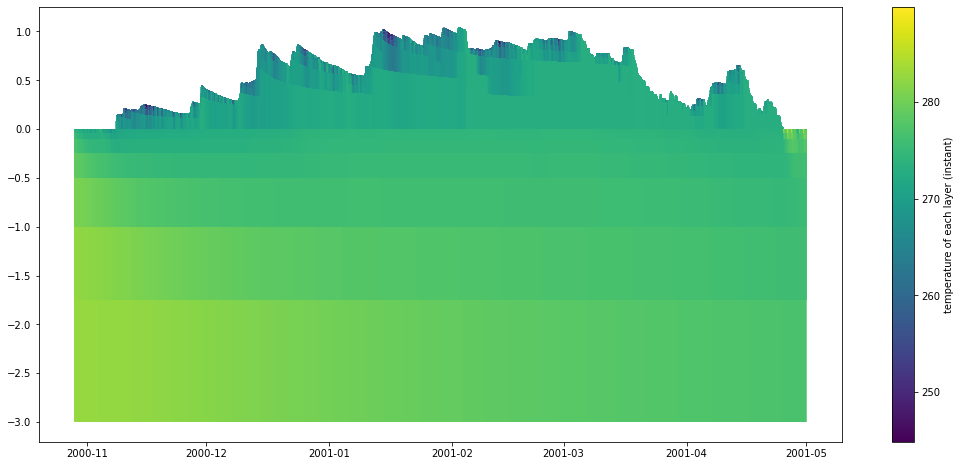

In [3]:
time_range = slice('10-29-2000', '04-30-2001')
depth    = ds.isel(hru=0).sel(time=time_range)['iLayerHeight']
temp     = ds.isel(hru=0).sel(time=time_range)['mLayerTemp']
psp.layers(temp, depth)

### Further customizations and integration with other plots
The previous example gives a good first cut of a plot, but it is not quite publication ready. 
In this section you will learn how to integrate the `psp.layers` functionality into a more general plotting 
workflow. Suppose here that we want only to plot the snow domain at a daily timescale, along with plots of 
the daily precipitation and air temperature.

To do so we will first resample the `depth` and `temp` variables to a daily timestep via the `xarray resample` method.
Then, we will set up the figure with three subplots. Finally, we will do some customization on the `psp.layers` call.
Finally, we'll add the other two subplots with the air temperature and precipitation timeseries.

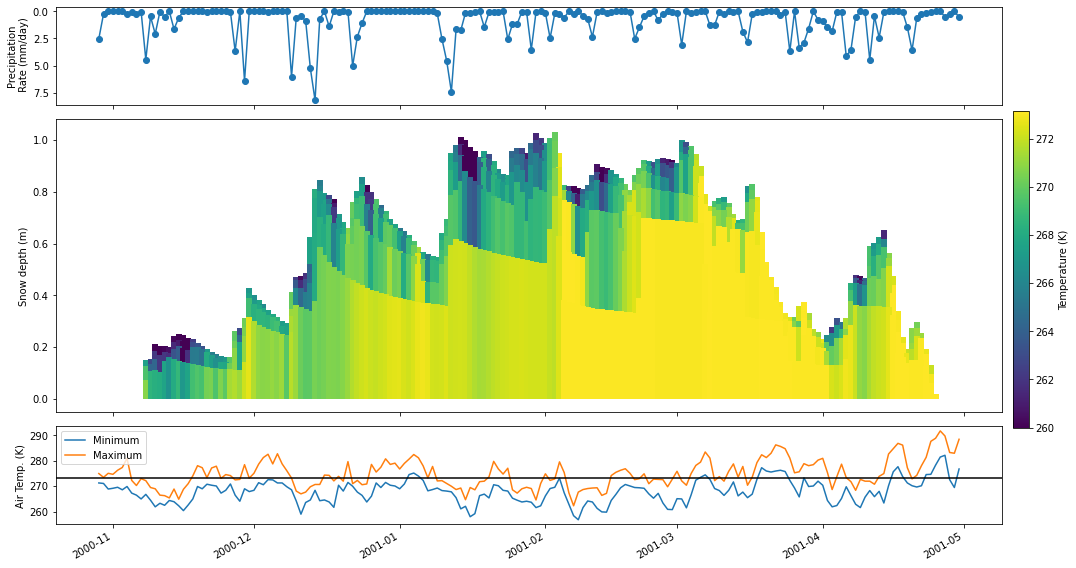

In [4]:
# Create the figure
fig, axes = plt.subplots(3, 1, figsize=(14, 8), gridspec_kw={'height_ratios': [1, 3, 1]}, sharex=True)
# Add a new axis for the colorbar
cax = fig.add_axes([0.15, 0.25, 1, 0.55])
cax.axis('off')

# Calculate the daily values
depth        = depth.resample({'time': 'D'}).mean()
temp         = temp.resample({'time': 'D'}).mean()
precip       = (1000 * ds['pptrate'].isel(hru=0).sel(time=time_range).resample({'time': 'D'}).sum())
airtemp_mean = ds['airtemp'].isel(hru=0).sel(time=time_range).resample({'time': 'D'}).mean()
airtemp_max  = ds['airtemp'].isel(hru=0).sel(time=time_range).resample({'time': 'D'}).max()
airtemp_min  = ds['airtemp'].isel(hru=0).sel(time=time_range).resample({'time': 'D'}).min()

# Do the layers plot
psp.layers(temp, depth, ax=axes[1], 
           variable_range=[260, 273.15],                         # Set a range for the colors
           line_kwargs={'linewidth': 6},                         # Wider linewidth because we are plotting daily
           cbar_kwargs={'label': 'Temperature (K)', 'ax': cax},  # Colorbar arguments
           plot_soil=False)                                      # Limit to the snow domain

# Add the precip and temperature plots
precip.plot(ax=axes[0], marker='o')
airtemp_min.plot(ax=axes[2], label='Minimum')
airtemp_max.plot(ax=axes[2], label='Maximum')
axes[2].legend()

# Set some axis labels
axes[2].axhline(273.16, color='black')
axes[0].invert_yaxis()
[a.set_xlabel('') for a in axes]
[a.set_title('') for a in axes]
axes[0].set_ylabel('Precipitation\n Rate (mm/day)')
axes[1].set_ylabel('Snow depth (m)')
axes[2].set_ylabel('Air Temp. (K)')
plt.tight_layout()

## Hovmöller diagrams

`pysumma` also provides some basic support for [Hovmöller diagrams](https://en.wikipedia.org/wiki/Hovm%C3%B6ller_diagram), which allow for comparing variables over different coordinates such as temporal aggregations or spatial dimensions. We first start with a plot that shows the average soil temperature for each day of year. Admittedly, this could be calculated and plotted via the `psp.layers` function described above, and would show the actual layer depths, but this gives one example of how this function can mix and match spatial and temporal dimensions. To do so we do have to pull a trick in reindexing so that soil layers fall in the last index of the `midToto` dimension (`midToto` being the middle of the layer, rather than the interfaces which are denoted by `ifcToto`).

Regardless, we group any `psp.hovmoller` call by an `xdim` and `ydim`. Here we include the `xdim` as `dayofyear` which will average the temperature for each day of the year over the simulation period. Similarly, we'll set the `ydim` as `midToto`, which is the depth dimension in the output dataset from the SUMMA simulation. We see here that there are higher frequency oscillations in the upper layers, as well as a more pronounced seasonal cycle. in the deeper layers we see a dampened and delayed response.

Text(0.5, 0, 'Day of year')

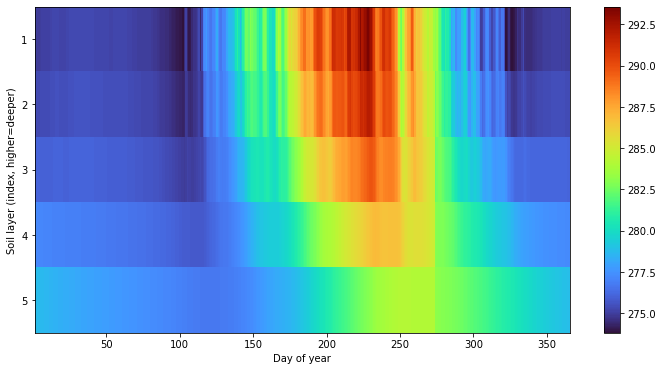

In [5]:
# Reindex so that the bottom layers are the soil layers
mlayertemp = ds['mLayerTemp'].isel(hru=0)
mlayertemp.values = psp.utils.justify(mlayertemp.where(mlayertemp > -900).values)
mlayertemp = mlayertemp.isel(midToto=slice(-6, None))

fig, ax = plt.subplots(figsize=(12, 6))
psp.hovmoller(mlayertemp, 'dayofyear', 'midToto', ax=ax, colormap='turbo')
ax.invert_yaxis()
ax.set_yticks([0.5, 1.5, 2.5, 3.5, 4.5])
ax.set_yticklabels([1, 2, 3, 4, 5])
ax.set_ylabel('Soil layer (index, higher=deeper)')
ax.set_xlabel('Day of year')

### Further customizations

As with the `psp.layers` function you can tie in the `psp.hovmoller` functionality with the broader Python plotting ecosystem. For example, let's look at how the net radiation is partitioned to latent and sensible heat. In this case we'll aggregate over two temporal dimensions (month of year and hour of day). These are specified by the `xdim` and `ydim` arguments to the `psp.hovmoller` function. Valid time grouper dimensions include `year, month, day, hour, minute, dayofyear, week, dayofweek, and quarter`.

Text(0.5, 1.0, 'Sensible heat flux')

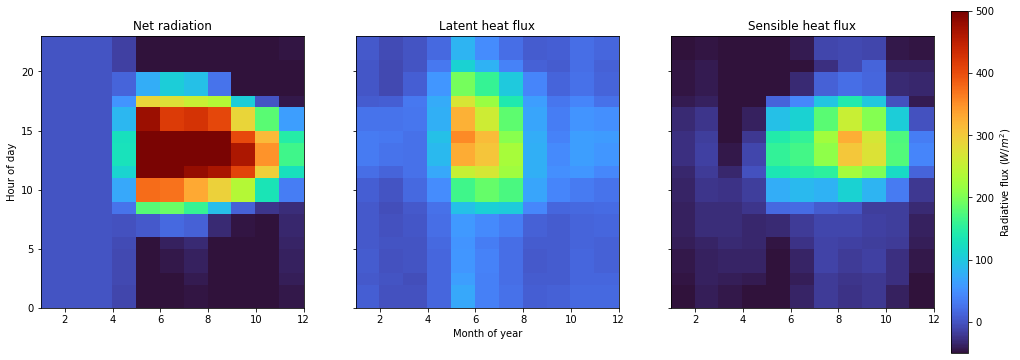

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)
time_range = slice('01-01-2001', '01-01-2002')
netrad = ds['scalarNetRadiation'].isel(hru=0).sel(time=time_range)
latheat = -ds['scalarLatHeatTotal'].isel(hru=0).sel(time=time_range)
senheat = -ds['scalarSenHeatTotal'].isel(hru=0).sel(time=time_range)

# Colorbar axis
cax = fig.add_axes([0.15, 0.0, 0.9, 0.95])
cax.axis('off')

# Range for colormap
vrange = [-50, 500]

psp.hovmoller(netrad,  'month', 'hour', variable_range=vrange, colormap='turbo', ax=axes[0], add_colorbar=False)
psp.hovmoller(latheat, 'month', 'hour', variable_range=vrange, colormap='turbo', ax=axes[1], add_colorbar=False)
psp.hovmoller(senheat, 'month', 'hour', variable_range=vrange, colormap='turbo', ax=axes[2], cbar_kwargs={'ax': cax, 'label': 'Radiative flux ($W/m^2$)'})

axes[1].set_xlabel('Month of year')
axes[0].set_ylabel('Hour of day')
axes[0].set_title('Net radiation')
axes[1].set_title('Latent heat flux')
axes[2].set_title('Sensible heat flux')

## Spatial plots

`pysumma` also offers some basic plotting capabilities for spatially distributed runs, provided you are able to also supply a shapefile describing the geometry of the simulation domain. To demonstrate this capability we will need to set up and run a `ps.Distributed` simulation. For more details on the usage of  `ps.Distributed` see the associated documents. To do this, we'll instantiate a `ps.Distributed` object with the example data from the Yakima river basin in the Pacific Northwestern United States.

The simulation itself may take some time to run, and once finished we will use the `merge_output` method to merge all of the simulations together and get a complete dataset from the simulation. Then we can plot the spatial fields using `psp.spatial`. This function takes either a single time slice or an aggregation over the simulation time period. In this case we'll just take the mean of the input air temperature.

In [7]:
!cd ../tutorial/data/yakima && ./install_local_setup.sh && cd -

shapefile = '../tutorial/data/yakima/shapefile/yakima.shp'
file_manager = '../tutorial/data/yakima/file_manager.txt'
gdf = gpd.GeoDataFrame.from_file(shapefile)
yakima = ps.Distributed('summa.exe', file_manager)
yakima.run()
assert np.alltrue([s.status == 'Success' for s in yakima.simulations.values()])

yakima_ds = yakima.merge_output()

/home/bzq/workspace/pysumma/docs


<GeoAxesSubplot:>

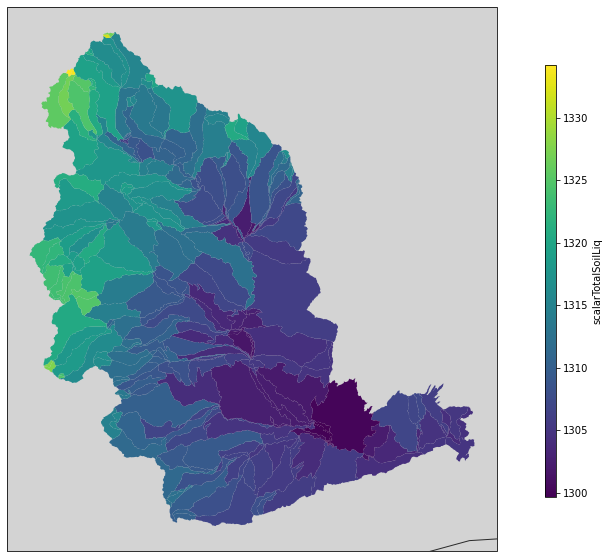

In [8]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection':ccrs.Mercator()})

psp.spatial(yakima_ds['scalarTotalSoilLiq'].mean(dim='time'), gdf, ax=ax)